## Projeto 3 - Classificador de fraude de cartão de crédito ##

Gabriel Monteiro e Rafael Vieira

Esse projeto teve como objetivo criar classificador de fraudes de cartão de crédito. O interesse veio por se tratar de algo do nosso dia a dia e pelo conhecimento que isso podia trazer. O dataset escolido traz 284807 transações realizadas fornecidas por um banco e com 'features', que são fatores que o banco julga importante para se diferenciar uma transação comúm de um transação fraudulenta. Essas 'features' são confidenciais e por isso não sabemos ao certo do que se tratam.

___
IMPORTANTE!!!
O ARQUIVO DE DADOS POSSUI 144Mbytes, PORTANTO NÃO PODE SER ENVIADO PELO GITHUB. O LINK DELE ESTÁ DISPONIBILIZADO ABAIXO:
https://www.kaggle.com/dalpozz/creditcardfraud

In [171]:
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from numpy import zeros_like
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import seaborn as sns
import matplotlib.gridspec as gridspec

In [172]:
df = pd.read_csv('creditcard.csv',sep=",")

In [173]:
len(df)

284807

___
## Implementação do Classificador ##

Para iniciar as análises , optamos por separar o dataset em uma base de treinamento contendo 70% dos dados, e uma base de teste contendo os restantes 30%. É importante se destacar que a base de dados possui apenas 0,2% de fraudes no total de transação. Essa informação será importante para futuras análises.

In [174]:
# separando dataset em base de treinamento e em base de teste


clas = df['Class'].values #fraude ou não
feat = df.drop(['Class'],axis=1).values #features
feat_train, feat_test, clas_train, clas_test = train_test_split(feat, clas, test_size=0.3, stratify=clas)

print("Tamanho da base treinamento: ", len(clas_train))
print("Fraudes na base treinamento: ", sum(clas_train))
print("Tamanho da base teste: ", len(clas_test))
print("Fraudes na base teste: ", sum(clas_test))

Tamanho da base treinamento:  199364
Fraudes na base treinamento:  344
Tamanho da base teste:  85443
Fraudes na base teste:  148


pq a regressão logistica

In [175]:
#regressão logistíca

rl = LogisticRegression()
rl.fit(feat_train,clas_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [176]:
probs = rl.predict_proba(feat_test)
probs_frame = pd.DataFrame(probs)
probs_frame.head()

,0,1
0,0.999988,0.000012
1,0.999999,0.000001
2,0.999986,0.000014
3,0.993627,0.006373
4,0.999122,0.000878


In [177]:
classe_teste = pd.DataFrame(clas_test)

In [178]:
for index, row in probs_frame.iterrows():
    i = probs_frame.index.get_loc(index)
    if probs[i][0]>probs[i][1]:
        probs_frame.loc[index, 'Classificação'] = 0
    if probs[i][0]<probs[i][1]:
        probs_frame.loc[index, 'Classificação'] = 1

## Primeiros resultados ##

In [179]:
Comparativo_log = pd.crosstab(classe_teste[0],probs_frame['Classificação'])
Comparativo_log

Classificação,0.0,1.0
0,,
0,85267,28
1,61,87


O classificador se mostrou muito preciso quanto a indentificar transações comúns , errando menos de 1%. No entanto não mostrou a mesma eficiência ao classificar as transações fraudulentas, tendo um acerto de apenas 55%. Levando em conta que um pouco menos da metade das fraudes passariam despecebidas , esse número está um pouco distante do que um banco busca.

___
## Aumentando a Sensibilidade ##

Os 28 V's fornecidos no dataset foram obtidos através de uma análise de componentes principais(PCA), que é uma técnica para sumarizar dados de muitas variáveis em um número menor de variáveis, fornecendo uma representação mais compacta. Assim , essa PCA traz correlações entre ser ou não fraude, porém não sabemos se estas possuem peso na hora de classificar uma transação como fraude ou não. Para analisarmos isso, podermos aumentar a sensibilidade do modelo buscando evitar um sobreajuste , que se trata de quando as 'features' se ajustam ao modelo, já que vieram de uma técnica de PCA , entretanto não possuem um significado que pode nos ajudar a prever algum resultado , que é o nosso maior objetivo.

C:\Users\gabri\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


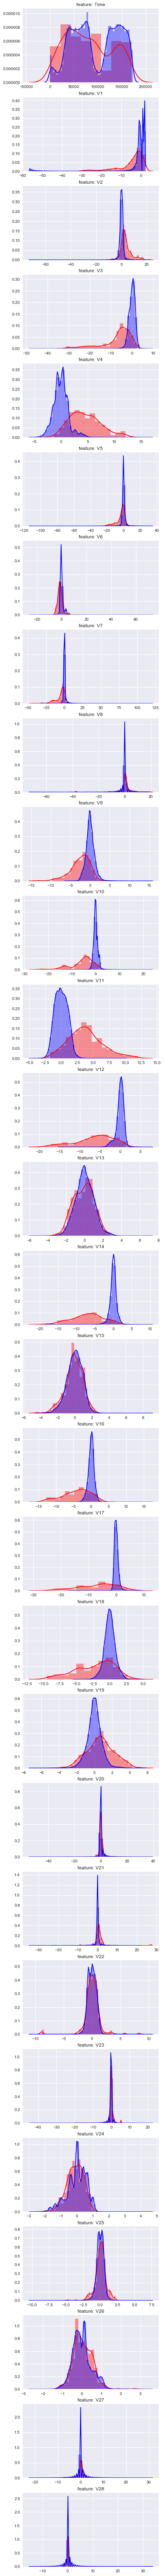

In [180]:
#Avaliando principais features através de histogramas de transações normais e transações fraudulentas 
gs = gridspec.GridSpec(29, 1)
plt.figure(figsize=(6,29*4))
for i, col in enumerate(df[df.iloc[:,0:29].columns]):
    ax1 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1] ,color='r')
    sns.distplot(df[col][df.Class == 0] ,color='b')
    ax1.set_xlabel('')
    ax1.set_title('feature: ' + str(col))
plt.show()

###  ERRO E PQ NÃO APARECE v28 ##

Através de uma análise gráfica , foi constatado que muitas das 'features' possuem a mesma influência em dizer se é fraude ou não. O valor dessas acusa uma classificação de fraude e de não fraude ao mesmo tempo, visto que suas áreas do gráfico em ambas as possibilidades são muito próximas. A retirada dessas variáveis podem evitar o sobreajuste abordado a cima. Agora , será feita um novo classificador com a  retirada dessas variáveis para se testar a hipótese.

In [181]:
########## Classificando agora sem as features que não se mostravam relevantes
irrelevantes = [0,9,14,16,21,23,24,25,26,27,28,29]
#df_select =  df.drop(irrelevantes,axis=1)

drop_frame_train = pd.DataFrame(feat_train)
drop_frame_test = pd.DataFrame(feat_test)
for i in range(len(irrelevantes)):
    drop_frame_train =  drop_frame_train.drop(irrelevantes[i],axis=1)
    drop_frame_test =  drop_frame_test.drop(irrelevantes[i],axis=1)
feat_train = drop_frame_train.values
feat_test = drop_frame_test.values

In [182]:
rl.fit(feat_train,clas_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [183]:
classe_teste = pd.DataFrame(clas_test)
probs = rl.predict_proba(feat_test)
probs_frame = pd.DataFrame(probs)
probs_frame.head()

,0,1
0,0.999895,0.000105
1,0.999758,0.000242
2,0.998269,0.001731
3,0.998689,0.001311
4,0.999608,0.000392


In [184]:
for index, row in probs_frame.iterrows():
    i = probs_frame.index.get_loc(index)
    if probs[i][0]>probs[i][1]:
        probs_frame.loc[index, 'Classificação'] = 0
    if probs[i][0]<probs[i][1]:
        probs_frame.loc[index, 'Classificação'] = 1

In [185]:
Comparativo_select= pd.crosstab(classe_teste[0],probs_frame['Classificação'])
Comparativo_select

Classificação,0.0,1.0
0,,
0,85282,13
1,53,95


Visivelmente o classificador se mostrou melhor quando retirada as algumas das 'features' que podem confirmar a hipótese de que houvesse um sobreajuste de algumas delas que dificultava a geração de resultados, já que o número de positivos verdadeiros subiu para 66%.

___
## Melhoria final ##

Para finalizar nosso classificador , buscamos estudar a situação dos falsos negativos que ainda não se parece aceitável.

In [192]:
#graficos de analise do cut off

In [186]:
#parte final
# Num dataframe de apenas fraudes analisar as prob e achar cut off ideal

In [187]:
probs_frame['Classificação Real']=classe_teste[0]

In [191]:
#filtro de falsos negativos
probs_frame[(probs_frame['Classificação Real']==1) & (probs_frame['Classificação']==0)].head()

,0,1,Classificação,Classificação Real,Filtro final
1433,0.992060,0.007940,0.0,1,0.0
2939,0.994042,0.005958,0.0,1,0.0
3718,0.760764,0.239236,0.0,1,1.0
5936,0.815606,0.184394,0.0,1,1.0
7358,0.997516,0.002484,0.0,1,0.0


In [189]:
for index, row in probs_frame.iterrows():
    i = probs_frame.index.get_loc(index)
    if probs[i][1]<0.008:
        probs_frame.loc[index, 'Filtro final'] = 0
    if probs[i][1]>0.008:
        probs_frame.loc[index, 'Filtro final'] = 1

In [190]:
Comparativo_select= pd.crosstab(classe_teste[0],probs_frame['Filtro final'])
Comparativo_select

Filtro final,0.0,1.0
0,,
0,84958,337
1,19,129


___
## Conclusões ##
